In [156]:
import pandas as pd
raw = pd.read_csv('data/1003.csv')
raw.timestamp = pd.to_datetime(raw.timestamp)
raw.set_index('timestamp', inplace=True)
raw.head()

,room_id,co2,temperature,humidity
timestamp,,,,
2022-11-16 15:30:02+00:00,37239,1371,19.6,48
2022-11-16 15:32:02+00:00,37239,1367,19.6,48
2022-11-16 15:34:02+00:00,37239,1390,19.6,48
2022-11-16 15:36:02+00:00,37239,1384,19.6,48
2022-11-16 15:38:02+00:00,37239,1377,19.6,48


In [159]:
df = raw.copy().between_time('07:30', '16:30')
df = df[~df.index.dayofweek.isin([5, 6])]
df['date'] = df.index.date
df['time'] = df.index.time

df = df[df['co2'] < 5000]
df = df[df['co2'] > 600]
df = df[df['temperature'].notna()]
df.head()

,room_id,co2,temperature,humidity,date,time
timestamp,,,,,,
2022-11-16 15:30:02+00:00,37239,1371,19.6,48,2022-11-16,15:30:02
2022-11-16 15:32:02+00:00,37239,1367,19.6,48,2022-11-16,15:32:02
2022-11-16 15:34:02+00:00,37239,1390,19.6,48,2022-11-16,15:34:02
2022-11-16 15:36:02+00:00,37239,1384,19.6,48,2022-11-16,15:36:02
2022-11-16 15:38:02+00:00,37239,1377,19.6,48,2022-11-16,15:38:02


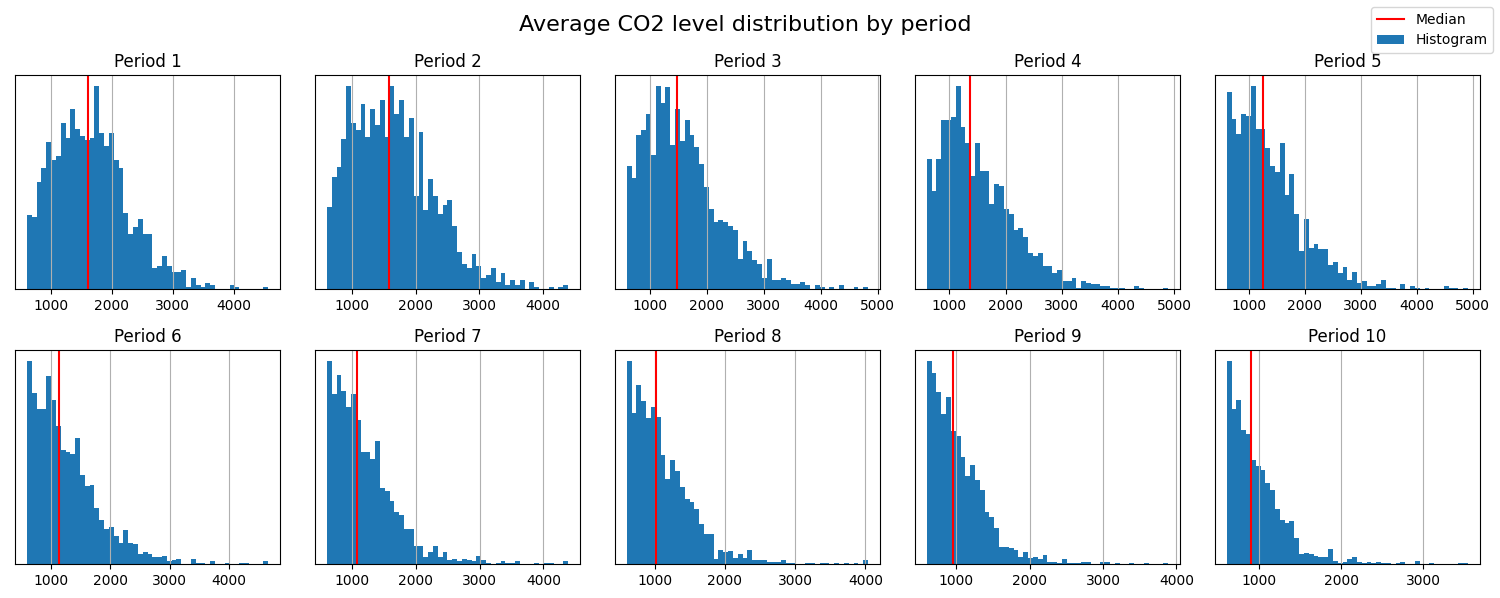

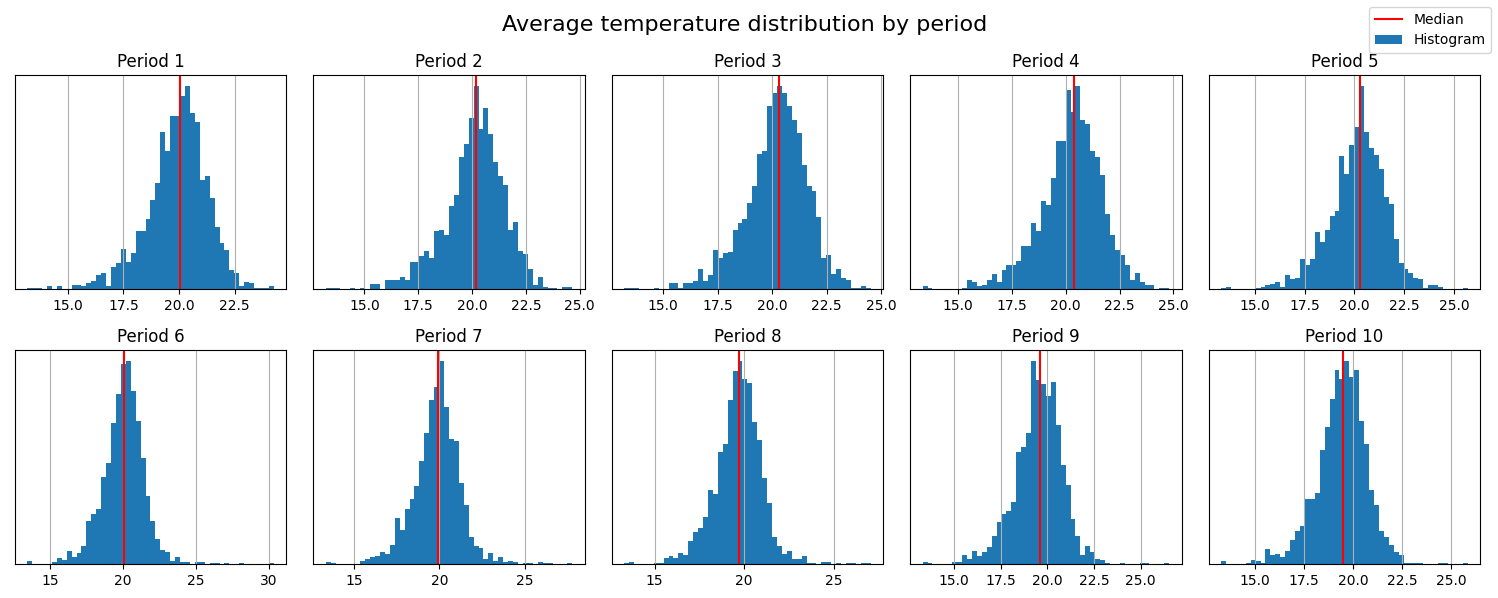

In [176]:
import matplotlib.pyplot as plt

df['minutes'] = df.index.hour * 60 + df.index.minute - (7 * 60 + 30)

def get_lesson_time(time):
    lesson = time / 50
    if lesson % 1 > 0.8:
        return -1
    return  lesson // 1

df['lesson'] = df.minutes.apply(get_lesson_time)
df = df[df['lesson'] != -1]
df.drop(columns=['minutes'], inplace=True)

lesson_df = df.groupby(['room_id', 'date', 'lesson']).mean(numeric_only=True).reset_index()
lesson_df.head()



fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(f"Period {i+1}")
    lesson_df[lesson_df['lesson'] == i+1].co2.hist(ax=ax, bins=50)
    ax.axvline(lesson_df[lesson_df['lesson'] == i+1].co2.median(), color='red')
    ax.get_yaxis().set_visible(False)

fig.legend(['Median', 'Histogram'], loc='upper right')
plt.suptitle('Average CO2 level distribution by period', fontsize=16)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(f"Period {i+1}")
    lesson_df[lesson_df['lesson'] == i+1].temperature.hist(ax=ax, bins=50)
    ax.axvline(lesson_df[lesson_df['lesson'] == i+1].temperature.median(), color='red')
    ax.get_yaxis().set_visible(False)

fig.legend(['Median', 'Histogram'], loc='upper right')
plt.suptitle('Average temperature distribution by period', fontsize=16)
plt.tight_layout()
plt.show()

In [161]:
lesson_df['z_temp'] = lesson_df.groupby(['room_id', 'date'])['temperature'].transform(lambda x: (x - x.mean()) / x.std())
lesson_df['z_hum'] = lesson_df.groupby(['room_id', 'date'])['humidity'].transform(lambda x: (x - x.mean()) / x.std())
lesson_df['z_co2'] = lesson_df.groupby(['room_id', 'date'])['co2'].transform(lambda x: (x - x.mean()) / x.std())
lesson_df.head()

,room_id,date,lesson,co2,temperature,humidity,z_temp,z_hum,z_co2
0,37226,2022-09-07,9.0,613.000000,21.200000,49.000000,NaN,NaN,0.707107
1,37226,2022-09-07,10.0,606.833333,21.200000,49.000000,NaN,NaN,-0.707107
2,37226,2022-09-08,0.0,930.476190,21.323810,44.857143,-1.204988,2.096867,1.163445
3,37226,2022-09-08,1.0,921.000000,21.509524,43.714286,-0.539186,1.507544,1.091474
4,37226,2022-09-08,2.0,658.500000,21.562500,40.750000,-0.349262,-0.021014,-0.902208
